# PYBOR
PYBOR is multi-curve interest rate framework and risk engine based on multivariate optimization technique

Copyright &copy; 2017 Ondrej Martinsky, All rights reserved

[www.github.com/omartinsky/pybor](https://github.com/omartinsky/pybor)

In [1]:
%pylab
%matplotlib inline
%run jupyter_helpers
%run yc_framework
import re, random

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Pricing Curve Map
Generate pricing curvemap using stochastic short-rate model. This curvemap will be used only to reprice market instruments

In [2]:
def generate_pricing_curvemap():
    random.seed(0)
    pricing_curvemap = CurveMap()
    t = linspace(0, 365*80, 7)
    def createCurve(name, r0, speed, mean, sigma):
        return CurveConstructor.FromShortRateModel(name, t, r0, speed, mean, sigma, interpolation=InterpolationMode.CUBIC_LOGDF)
    def createCurveFromSpread(baseCurve, name, r0, speed, mean, sigma):
        out = createCurve(name, r0, speed, mean, sigma)
        out.add_another_curve(baseCurve)
        return out
    u3m = createCurve('USDLIBOR3M', 0.02, 0.03, 0.035, 5e-4)
    u6m = createCurveFromSpread(u3m, 'USDLIBOR6M', 0.01, 0.03, 0.011, 5e-4)
    u12m = createCurveFromSpread(u6m, 'USDLIBOR12M', 0.01, 0.03, 0.011, 5e-4)
    g3m = createCurveFromSpread(u3m, 'GBPLIBOR3M', 0.03, 0.03, 0.0, 5e-4)
    u1b = createCurve('USD-USDOIS', 0.01, 0.03, 0.011, 5e-4)
    g1b = createCurveFromSpread(u1b, 'GBP-GBPSONIA', 0.005, 0.03, 0.005, 5e-4)
    gu1b = createCurveFromSpread(u1b, 'GBP-USDOIS', 0.001, 0.03, 0.001, 5e-4)
    pricing_curvemap.add_curve(u3m)
    pricing_curvemap.add_curve(u6m)
    pricing_curvemap.add_curve(u12m)
    pricing_curvemap.add_curve(g3m)
    pricing_curvemap.add_curve(g1b)
    pricing_curvemap.add_curve(u1b)
    pricing_curvemap.add_curve(gu1b)
    return pricing_curvemap

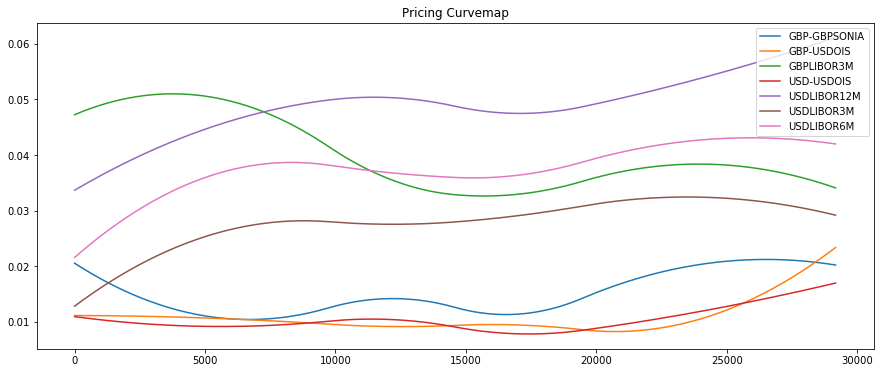

In [3]:
pricing_curvemap = generate_pricing_curvemap()
# Display:
figsize(15,6)
linestyle('solid'), pricing_curvemap.plot(), title('Pricing Curvemap'), legend(), show();

## Curve Builder
Create curve builder and use previously generated pricing curvemap to reprice market instruments

In [4]:
curve_builder = CurveBuilder('engine_usd_gbp.xlsx', 0, progress_monitor=ProgressMonitor())

### Instrument Repricing
Use curve Builder to reprice instruments from previously created curve map

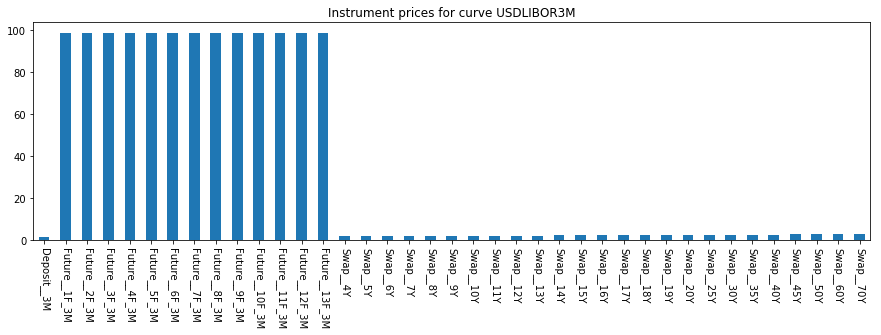

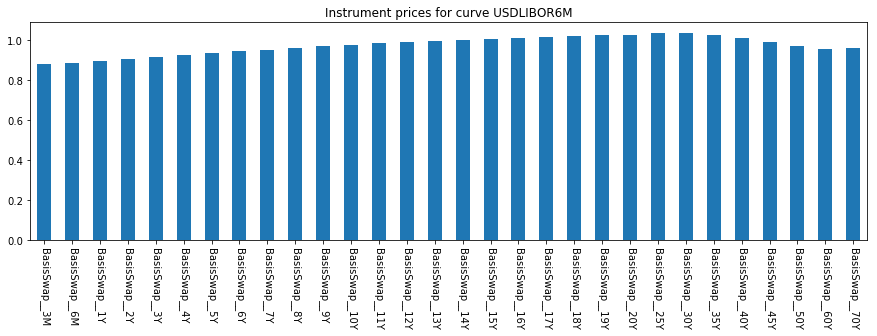

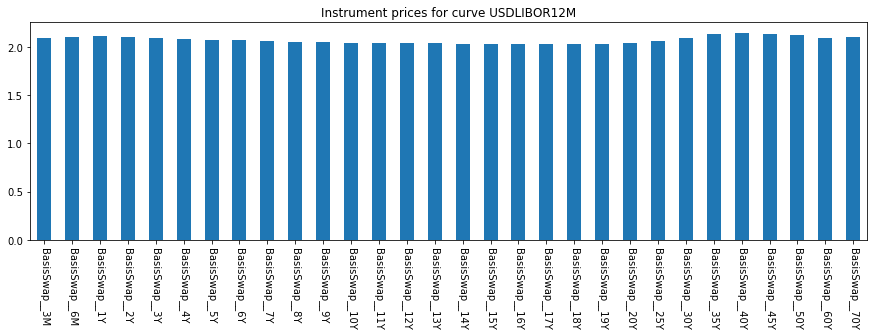

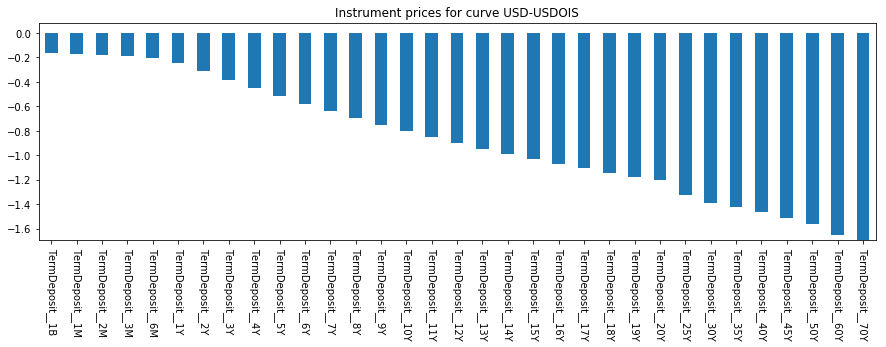

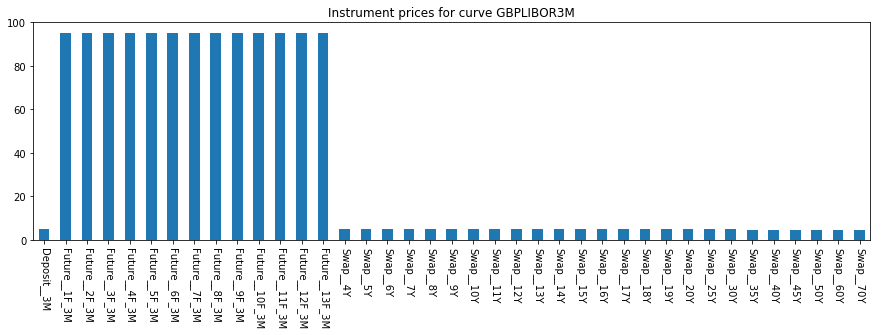

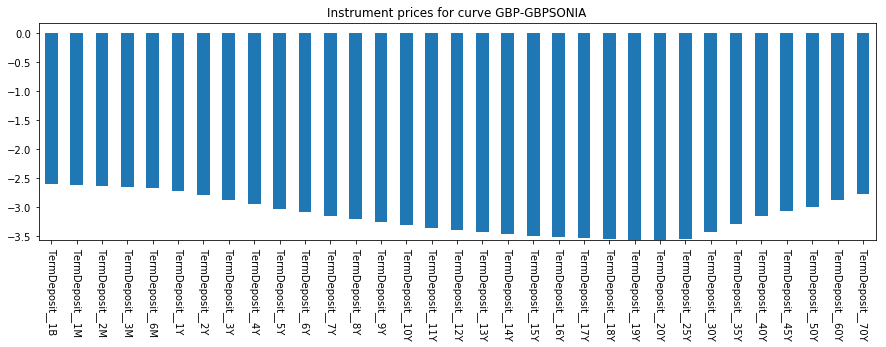

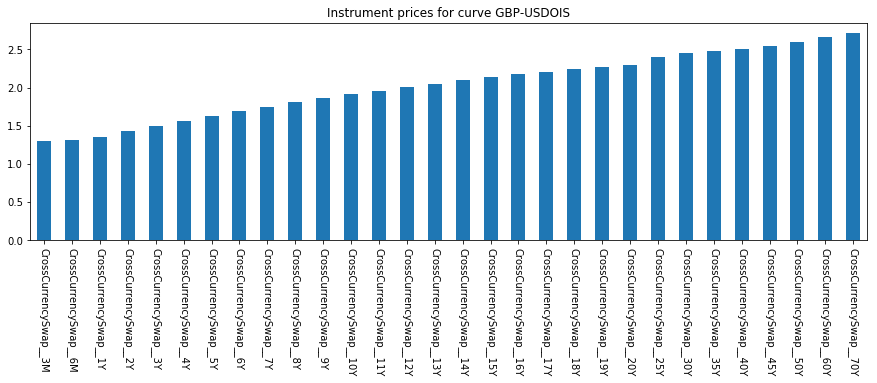

In [5]:
price_ladder = curve_builder.reprice(pricing_curvemap)
curve_names = curve_builder.get_curve_names()
# Display:
figsize(15,4)
for curve_name in curve_names:
    df=price_ladder.sublist(curve_name).dataframe()
    df.index = [x[x.find('__')+2:] for x in list(df.index)]
    df.Price.plot(kind='bar', title='Instrument prices for curve %s' % curve_name, rot=270)
    show()

### Curve Building

In [6]:
build_output = curve_builder.build_curves(price_ladder)

Creating pillars 0 - 39 for curve USDLIBOR3M
Creating pillars 39 - 69 for curve USDLIBOR6M
Creating pillars 69 - 99 for curve USDLIBOR12M
Creating pillars 99 - 132 for curve USD-USDOIS
Creating pillars 132 - 171 for curve GBPLIBOR3M
Creating pillars 171 - 204 for curve GBP-GBPSONIA
Creating pillars 204 - 234 for curve GBP-USDOIS
.........100.........200.........300.........400.........500.........600.........700.........800.........900.........1000.........1100.........1200.........1300.........1400.........1500.........1600.........1700.........1800........

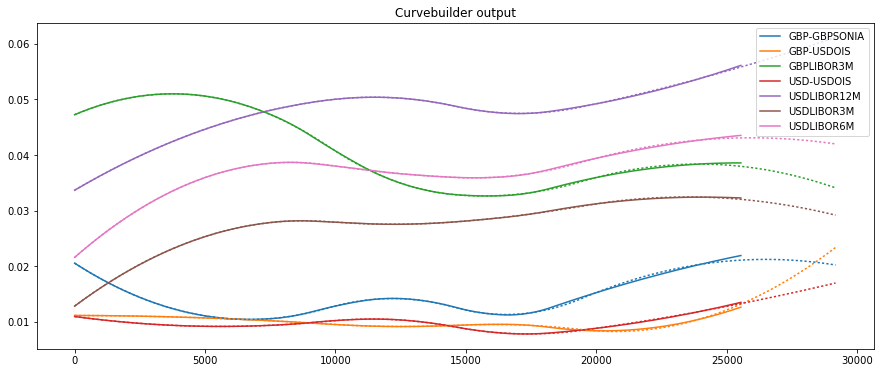

In [7]:
# Display:
figsize(15,6)
title('Curvebuilder output')
linestyle('solid'), build_output.output_curvemap.plot(), legend()
linestyle('dotted'), pricing_curvemap.plot()
show();

### Instrument/Pillar Jacobian Matrix
Jacobian matrix is a by-product of a curve-build

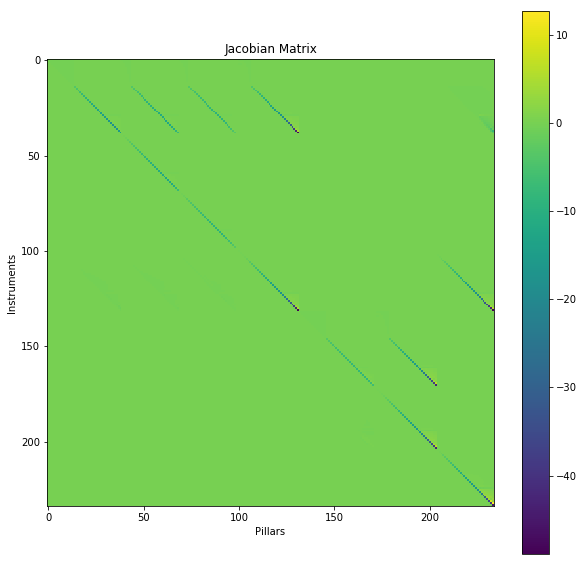

In [8]:
jacobian_dPdI = inv(build_output.jacobian_dIdP)
# Display:
figsize(10,10)
title("Jacobian Matrix"), xlabel('Pillars'), ylabel('Instruments')
imshow(jacobian_dPdI), colorbar();

## Risk Calculator


In [9]:
risk_calculator = RiskCalculator(curve_builder, build_output)

In [10]:
def visualise_bump(instrument_search_string, bumpsize):
    instruments, bumpsize = risk_calculator.find_instruments(instrument_search_string), bumpsize  
    curvemap_bump = risk_calculator.get_bumped_curvemap(instruments, bumpsize, BumpType.JACOBIAN_REBUILD)

    # Display:
    figsize(15,6)
    linestyle('solid'), build_output.output_curvemap.plot(), legend()
    linestyle('dashed'), curvemap_bump.plot()
    title("Effect of bumping instrument %s" % instrument_search_string)

### Bumping Market Instruments

Bumping **market instruments** (such as those which define USD LIBOR 3M neutral curve) will cause parallel shift of all other curves which are defined as a basis from this curve

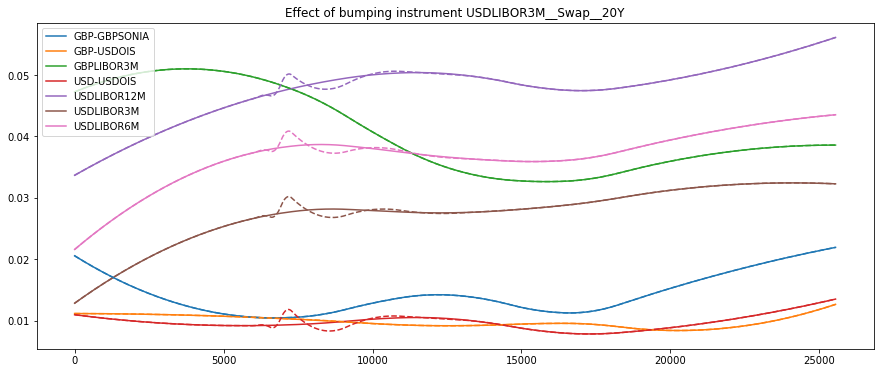

In [11]:
visualise_bump('USDLIBOR3M__Swap__20Y', 1e-4)

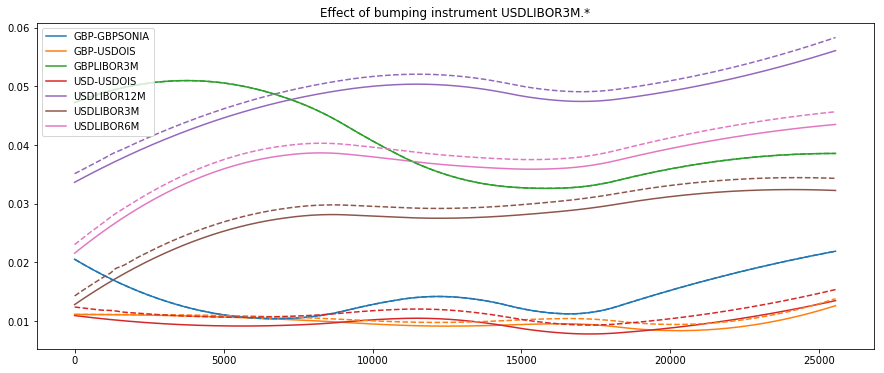

In [12]:
visualise_bump('USDLIBOR3M.*', 15e-4)

## Bumping Basis Instruments

Bumping **basis instruments** (USD LIBOR 6M) will cause movement in a USD LIBOR 6M basis curve

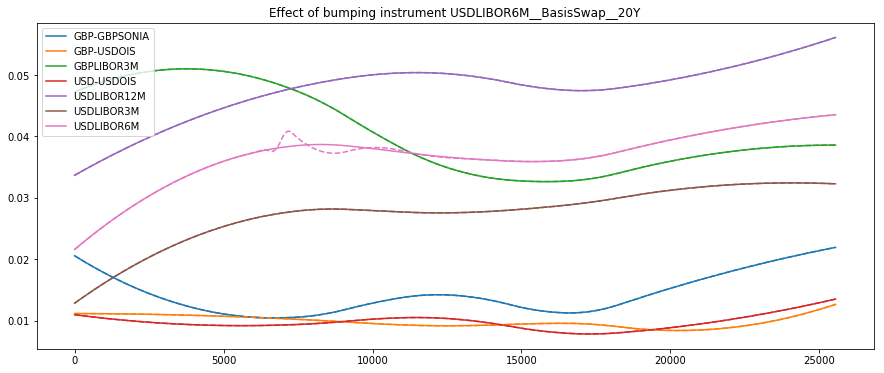

In [13]:
visualise_bump('USDLIBOR6M__BasisSwap__20Y', 1e-4)

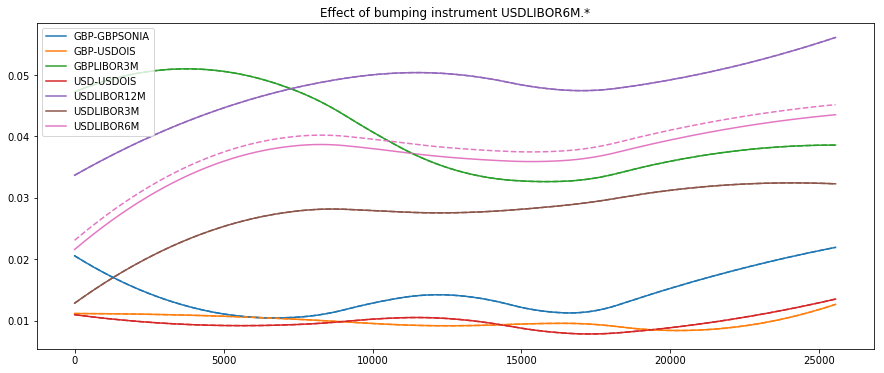

In [17]:
visualise_bump('USDLIBOR6M.*', 15e-4)